,dd,captured,population,active,eggs
76,76,0,1.491998,0,0
95,95,1,592.647544,488,0


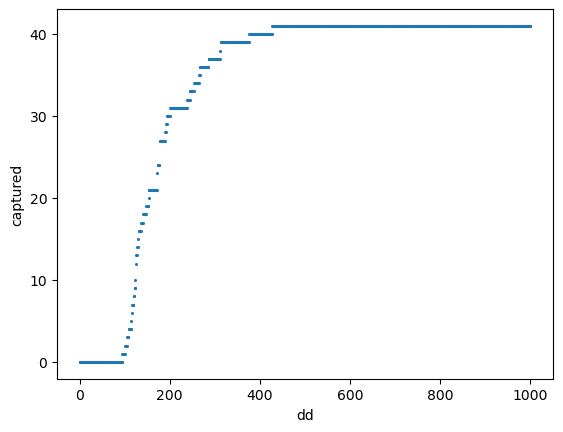

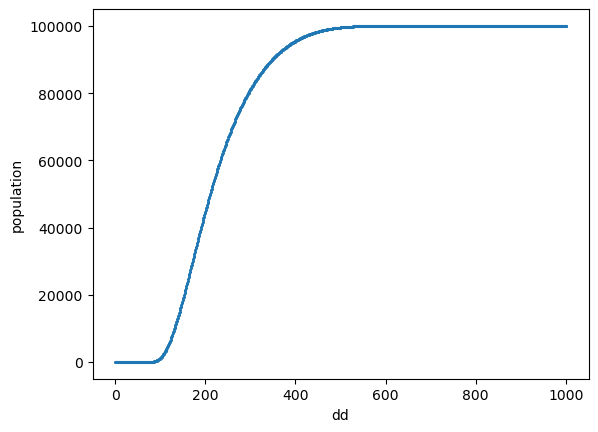

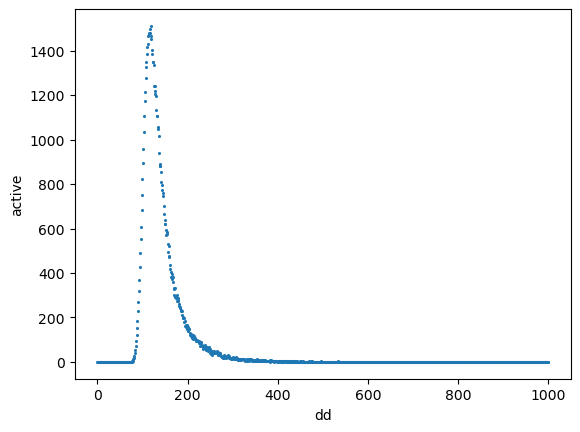

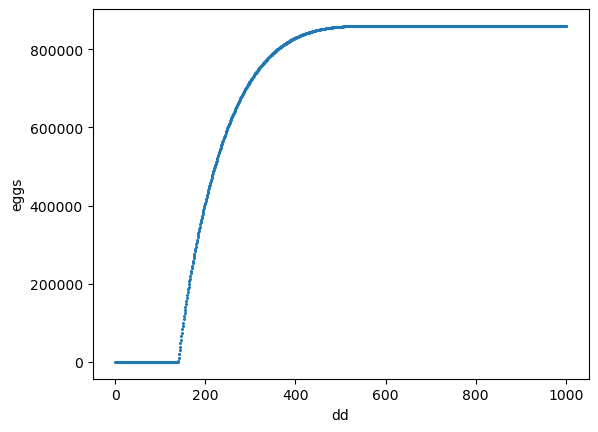

In [1]:
import pandas as pd
df = pd.read_csv('test_0.csv')
df.plot.scatter(0, 1, 1.5)
df.plot.scatter(0, 2, 1.5)
df.plot.scatter(0, 3, 1.5)
df.plot.scatter(0, 4, 1.5)
pd.concat([df[df.population >= 1].head(1), df[df.captured >= 1].head(1)])

In [2]:
df.tail(1).eggs / df.tail(1).population

1000    8.595
dtype: float64

In [3]:
df.iloc[450:600]

,dd,captured,population,active,eggs
450,450,41,98300.806046,2,849255
451,451,41,98338.082891,2,849517
452,452,41,98374.754845,0,849779
453,453,41,98410.828286,0,850041
454,454,41,98446.309557,0,850270
...,...,...,...,...,...
595,595,41,99997.859484,0,859500
596,596,41,99998.088755,0,859500
597,597,41,99998.298233,0,859500
598,598,41,99998.489176,0,859500


In [4]:
df.iloc[60:80]

,dd,captured,population,active,eggs
60,60,0,0.000000,0,0
61,61,0,0.000000,0,0
62,62,0,0.000000,0,0
63,63,0,0.000000,0,0
64,64,0,0.000000,0,0
65,65,0,0.000000,0,0
66,66,0,0.000000,0,0
67,67,0,0.000000,0,0
68,68,0,0.000000,0,0
69,69,0,0.000000,0,0


In [5]:
df.tail(1)

,dd,captured,population,active,eggs
1000,1000,41,100000.000003,0,859500
